In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import osmnx as ox
import pandas as pd
import pickle
import tensorflow as tf

In [2]:
tf.__version__

'1.12.0'

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Load the model
Load the training supposed best training checkpoint.

In [4]:
DATASET_NAME = 'cabspotting'
G_GRU_SIZE = 32
D_GRU_SIZE = 16

g_string = 'g_GRU-{g_gru_size}_rand-32_Dense-3_adam_bce_default_'.format(g_gru_size=G_GRU_SIZE)
d_string = 'd_gin_GRU-{d_gru_size}_Dense-1_adam_bce_default_'.format(d_gru_size=D_GRU_SIZE)
setup_string = g_string + d_string + '{dataset}_64_100'.format(dataset=DATASET_NAME)

In [5]:
setup_string

'g_GRU-32_rand-32_Dense-3_adam_bce_default_d_gin_GRU-16_Dense-1_adam_bce_default_cabspotting_64_100'

In [7]:
history = pickle.load(open('histories/citybased_gan_2/' + setup_string + '_30.pkl', 'rb'))

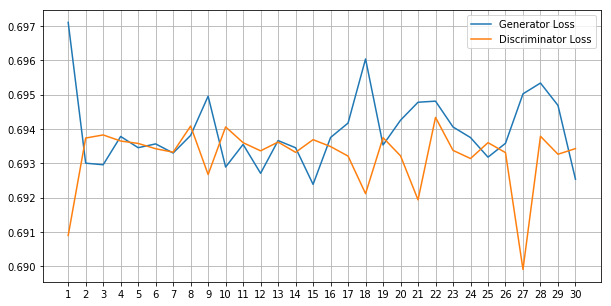

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 31, 1), history['g_loss'], label='Generator Loss')
plt.plot(np.arange(1, 31, 1), history['d_loss'], label='Discriminator Loss')
plt.xticks(np.arange(1, 31, 1))
plt.grid()
plt.legend()
plt.show()

In [9]:
SELECTED_EPOCH = 30

In [11]:
# Load the model
model_path = 'checkpoints/citybased_gan_2/' + setup_string + '_{:02d}_g.h5'.format(SELECTED_EPOCH)
model = tf.keras.models.load_model(model_path)

## Actual generation

In [12]:
N_USERS = 8

Generate user start positions

In [13]:
poskde = pickle.load(open('../data_{dataset}/poskde_{dataset}_000003.pkl'.format(dataset=DATASET_NAME), 'rb'))

In [14]:
startpositions = poskde.sample(N_USERS)

In [15]:
startpositions[:3]

array([[-122.41135979,   37.778865  ],
       [-122.43120341,   37.77548921],
       [-122.43203878,   37.7795545 ]])

Generate start and end times

In [16]:
BEGIN = pd.Timestamp('2008-05-17 10:00:04')
END = pd.Timestamp('2008-06-10 09:25:34')
#END = pd.Timestamp('2008-05-19 09:25:34')
total_duration = END - BEGIN

In [17]:
total_duration

Timedelta('23 days 23:25:30')

In [18]:
sekde = pickle.load(open('../data_{dataset}/sekde_{dataset}_003.pkl'.format(dataset=DATASET_NAME), 'rb'))

In [19]:
starttimes = np.full(N_USERS, -1.0)
out_of_range = (starttimes < 0) | (starttimes >= 1.0)

while np.any(out_of_range):
    new_samples = np.squeeze(sekde['kde_start'].sample(len(starttimes[out_of_range])))
    starttimes[out_of_range] = new_samples
    out_of_range = (starttimes < 0) | (starttimes >= 1.0)

In [20]:
starttimes[:3]

array([0.23741369, 0.00358957, 0.03552831])

In [21]:
durations = np.zeros(N_USERS)
out_of_range = (durations <= 0) | (starttimes + durations > 1.0)

while np.any(out_of_range):
    new_samples = np.squeeze(sekde['kde_duration'].sample(len(durations[out_of_range])))
    durations[out_of_range] = new_samples
    out_of_range = (durations <= 0) | (starttimes + durations > 1.0)

In [22]:
durations[:3]

array([0.04132075, 0.97580152, 0.34249835])

In [23]:
starttimes = starttimes * total_duration.total_seconds()
starttimes[:3]

array([491809.58373253,   7435.89228097,  73597.96200129])

In [24]:
durations = durations * total_duration.total_seconds()
durations[:3]

array([  85597.1784391 , 2021402.11468195,  709495.61290599])

In [25]:
starts = np.concatenate([starttimes.reshape(-1, 1), startpositions], axis=1)

In [26]:
starts[:3]

array([[ 4.91809584e+05, -1.22411360e+02,  3.77788650e+01],
       [ 7.43589228e+03, -1.22431203e+02,  3.77754892e+01],
       [ 7.35979620e+04, -1.22432039e+02,  3.77795545e+01]])

In [27]:
scaler = pickle.load(open('scalers/citybased_gan_2/' + setup_string + '.pkl', 'rb'))

/Users/jankaiser/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.2 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Actual generation loops

In [28]:
one_second = scaler.transform(np.array([[1.0, 0.0, 0.0]]))[0, 0]
one_second

-0.05818841174472069

In [58]:
def generate_user(generator, scaler, start, duration):
    sc = np.array([start])
    s = sc.copy()
    s[0, 0] = 0.0
    s = scaler.transform(s)   
    
    starttime = start[0]
    endtime = starttime + duration
    
    while(sc[-1, 0] <= endtime):
        print('\r{}'.format(len(sc)), end='')
        
        x = s
        noise = np.random.rand(32)
        
        y = model.predict([x.reshape(1, -1, 3), noise.reshape(1, 32)]).squeeze()
        y[0] = max(one_second, y[0])
        
        s = np.concatenate([s, y.reshape((1, 3))])
        
        yc = scaler.inverse_transform(y.reshape(1, 3)).squeeze()
        yc[0] = sc[-1, 0] + yc[0]
        
        sc = np.concatenate([sc, yc.reshape((1, 3))])
    
    return s[:-1]

In [59]:
data = []
for u in range(N_USERS):
    print(u)
    s = generate_user(model, scaler, starts[u], durations[u])
    data.append(s)

0
2084

KeyboardInterrupt: 

Inspect generated data

In [ ]:
i = 4